In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error, roc_auc_score
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.patches as  mpatches
import timeit


In [2]:
import xgboost
xgboost.__version__

'1.6.2'

In [3]:
df = pd.read_csv("/kaggle/input/finalcsv/finalApproved.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_reason,hardship_status,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,10000.0,10000.0,10000.0,36 months,7.21,309.74,A,A3,r.n. unit manager,10+ years,MORTGAGE,75000.0,Not Verified,2018-08-01,Current,n,other,Other,063xx,CT,34.22,0.0,Dec-2004,745.0,749.0,2.0,0.0,-1.0,15.0,0.0,17568.0,24.3,24.0,w,8220.58,8220.58,2158.17,2158.17,1779.42,378.75,0.0,0.0,0.0,Mar-2019,309.74,Apr-2019,Mar-2019,739.0,735.0,0.0,0.0,Individual,-1.0,-1.0,-1.0,0.0,0.0,250815.0,2.0,3.0,0.0,1.0,15.0,46721.0,64.0,2.0,3.0,2919.0,44.0,72400.0,1.0,2.0,2.0,4.0,16721.0,29299.0,30.1,0.0,0.0,123.0,164.0,3.0,3.0,2.0,17.0,0.0,3.0,0.0,0.0,6.0,9.0,6.0,6.0,9.0,11.0,13.0,9.0,15.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,356846.0,64289.0,41900.0,73506.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,N,noInfo,noInfo,-1.0,noInfo,noInfo,noInfo,-1.0,noInfo,-1.0,-1.0,-1.0,Cash,N,noInfo,noInfo,noInfo,-1.0,-1.0,-1.0
1,4000.0,4000.0,4000.0,36 months,9.43,128.01,B,B1,Real Estate Analyst,3 years,RENT,60000.0,Not Verified,2018-02-01,Current,n,other,Other,947xx,CA,11.64,0.0,May-2011,695.0,699.0,2.0,0.0,-1.0,11.0,0.0,13697.0,41.1,11.0,f,2683.57,2683.57,1662.03,1662.03,1316.43,345.60,0.0,0.0,0.0,Mar-2019,128.01,Apr-2019,Mar-2019,694.0,690.0,0.0,0.0,Individual,-1.0,-1.0,-1.0,0.0,0.0,48006.0,3.0,3.0,3.0,3.0,4.0,34309.0,93.0,2.0,5.0,6061.0,68.0,33300.0,0.0,0.0,4.0,8.0,4364.0,15003.0,47.7,0.0,0.0,12.0,81.0,4.0,4.0,0.0,4.0,0.0,5.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,8.0,8.0,3.0,11.0,0.0,0.0,5.0,100.0,25.0,0.0,0.0,70181.0,48006.0,28700.0,36881.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,N,noInfo,noInfo,-1.0,noInfo,noInfo,noInfo,-1.0,noInfo,-1.0,-1.0,-1.0,Cash,N,noInfo,noInfo,noInfo,-1.0,-1.0,-1.0
2,10000.0,10000.0,10000.0,36 months,11.06,327.68,B,B3,Senior 

# Prediction model for Grade

In [4]:
numerical_features = [
    'acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti',
       'dti_joint', 'fico_range_high', 'fico_range_low', 'funded_amnt',
       'funded_amnt_inv', 'hardship_amount', 'hardship_dpd',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'il_util', 'inq_fi', 'inq_last_12m', 'inq_last_6mths',
       'installment','last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt',
       'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_rcnt_il',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'open_rv_12m', 'open_rv_24m',
       'orig_projected_additional_accrued_interest', 'out_prncp',
       'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec',
       'pub_rec_bankruptcies', 'recoveries', 'revol_bal',
       'revol_bal_joint', 'revol_util',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog',
       'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il',
       'sec_app_revol_util', 'settlement_amount', 'settlement_percentage',
       'settlement_term', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort',
       'total_bal_il', 'total_bc_limit', 'total_cu_tl',
       'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'total_rev_hi_lim'
]
categorical_features = [
       'term', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title',
       'initial_list_status', 'last_pymnt_d',
       'verification_status_joint',
       'hardship_flag', 'hardship_reason',
       'hardship_status', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_loan_status',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'
]
label_column = 'grade'

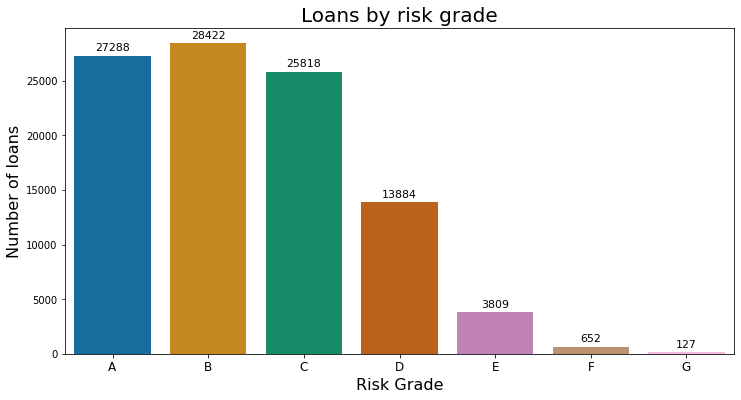

In [5]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='grade',data=df, order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("Risk Grade", fontsize = 16)
ax.set_ylabel("Number of loans", fontsize = 16)
ax.set_title("Loans by risk grade", fontsize = 20)
plt.show()

In [6]:
df.grade = df.grade.replace({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6} )

In [7]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify=df.grade)

# Base Line

In [8]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data[numerical_features + categorical_features], train_data[label_column])
dummy_pred = dummy_clf.predict(test_data[numerical_features + categorical_features])

In [9]:
y_test = test_data[label_column].to_numpy()

In [10]:
def print_results( y_pred, y_test, y_pred_prob):
    print('Test accuracy score: ' + str(accuracy_score( y_test,y_pred)))
    print('Test precision score: ' + str(precision_score(  y_test, y_pred, average='micro')))
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred_prob, average="weighted", multi_class="ovr")))

In [11]:
y_pred_prob = dummy_clf.predict_proba(test_data[numerical_features + categorical_features])
print_results(dummy_pred, y_test, y_pred_prob)

Test accuracy score: 0.2842
Test precision score: 0.2842
Test ROC AUC score: 0.5


# Grade prediction model

In [12]:
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="constant")),
        (
            "categorical_encoder",
            OneHotEncoder(handle_unknown='ignore'),
        ),
    ]
)

numerical_transformer = Pipeline(
    steps=[
        ("numerical_imputer", SimpleImputer(strategy="constant", fill_value = -999999)),
        (
            "numerical_scaler",
            StandardScaler(),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [13]:
model = XGBClassifier()

In [14]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [15]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 21min 52s, sys: 2.51 s, total: 21min 55s
Wall time: 5min 38s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'loan_status', 'pymnt_plan',
                                                   'purpose', 'title',
                                                   'initial_list_status',
                                                   'las...
        

In [16]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.95485
Test precision score: 0.95485
Test ROC AUC score: 0.9973660213193832


Feature importance

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


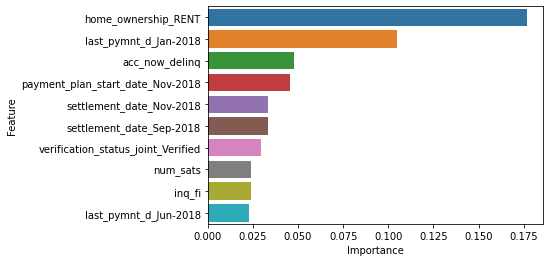

In [17]:
names_num = train_data[numerical_features].columns.values
names_cat = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps["categorical_encoder"].get_feature_names(categorical_features)
names = np.concatenate([names_num, names_cat])
imp = pipe.steps[1][1].feature_importances_
data = pd.DataFrame({'Feature': names, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);

Confusion matrix

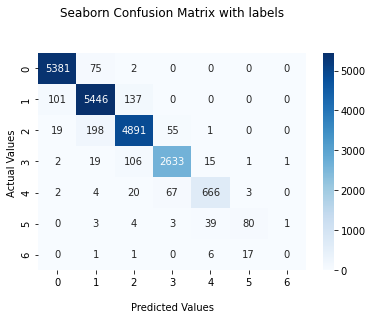

In [18]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0 ,1, 2, 3, 4, 5, 6])
ax.yaxis.set_ticklabels([0 ,1, 2, 3, 4, 5, 6])

plt.show()

# Making smaller model

In [19]:
numerical_features = [
    'acc_now_delinq'
]
categorical_features = [
    'verification_status',
    'title',
    'hardship_loan_status',
    'hardship_status',
    'debt_settlement_flag',
    'payment_plan_start_date',
    'last_pymnt_d'
]
label_column = 'grade'

In [20]:
preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            categorical_transformer,
            categorical_features,
        ),
        (
            "numerical",
            numerical_transformer,
            numerical_features,
        ),
    ]
)

In [21]:
pipe = Pipeline([("preprocessor", preprocessor),
                        ("model", model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status',
                                                   'title',
                                                   'hardship_loan_status',
                                                   'hardship_status',
                                                   'debt_settlement_flag',
                                                   'payment_plan_start_date',
                                                   'last_pymn...
           

In [22]:
%%time
pipe.fit(
    train_data[numerical_features + categorical_features], train_data[label_column]
)

CPU times: user 59.5 s, sys: 175 ms, total: 59.7 s
Wall time: 15.5 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['verification_status',
                                                   'title',
                                                   'hardship_loan_status',
                                                   'hardship_status',
                                                   'debt_settlement_flag',
                                                   'payment_plan_start_date',
                                                   'last_pymn...
           

In [23]:
y_test = test_data[label_column].to_numpy()
y_pred = pipe.predict(test_data[numerical_features + categorical_features])
y_pred_prob = pipe.predict_proba(test_data[numerical_features + categorical_features])
print_results(y_pred, y_test, y_pred_prob)

Test accuracy score: 0.32235
Test precision score: 0.32235
Test ROC AUC score: 0.5818455310256588


In [24]:
import joblib

filename = 'gradeModel.joblib'
joblib.dump(pipe, filename)



['gradeModel.joblib']

In [25]:
test_data[numerical_features + categorical_features].head(10)

,acc_now_delinq,verification_status,title,hardship_loan_status,hardship_status,debt_settlement_flag,payment_plan_start_date,last_pymnt_d
63890,0.0,Not Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Mar-2019
92130,0.0,Verified,Other,noInfo,noInfo,N,noInfo,Mar-2019
73054,0.0,Not Verified,Credit card refinancing,noInfo,noInfo,N,noInfo,Mar-2019
43039,0.0,Not Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Mar-2019
1395,0.0,Source Verified,Credit card refinancing,noInfo,noInfo,N,noInfo,Mar-2019
45174,0.0,Source Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Mar-2019
99725,0.0,Source Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Mar-2019
66912,0.0,Verified,Credit card refinancing,noInfo,noInfo,N,noInfo,Mar-2019
82316,0.0,Not Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Feb-2019
58148,0.0,Not Verified,Debt consolidation,noInfo,noInfo,N,noInfo,Mar-2019


In [26]:
import pickle

pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipe, file)